In [119]:
import urllib.request
import os.path
import gzip
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [120]:
url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.getcwd()
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    if os.path.exists(file_path):
        return
    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)
    
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    if not os.path.exists(save_file):
        init_mnist()
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)
    
    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [121]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [122]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [123]:
batch_size = 10
train_size = x_train.shape[0]
batch_mask = np.random.choice(train_size, batch_size) # random number
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [124]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

def cross_entropy_error_label(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [125]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

def tangent_line(f, x):
    d = numerical_diff(f, x)
    # print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

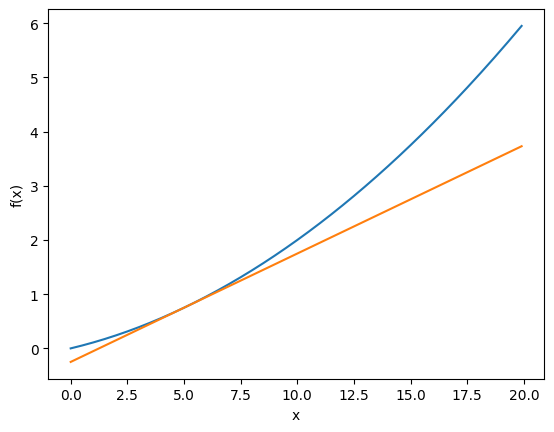

0.1999999999990898
0.2999999999986347


In [126]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

In [127]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # shape = x.shape, all 0
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    return grad

In [128]:
def function_2(x):
    return x[0]**2 + x[1]**2

print(numerical_gradient(function_2, np.array([3.0, 4.0])))

[6. 8.]


In [129]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [130]:
def gradient_descent_history(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    x_history = []
    for i in range(step_num):
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x, np.array(x_history)

[-6.11110793e-10  8.14814391e-10]


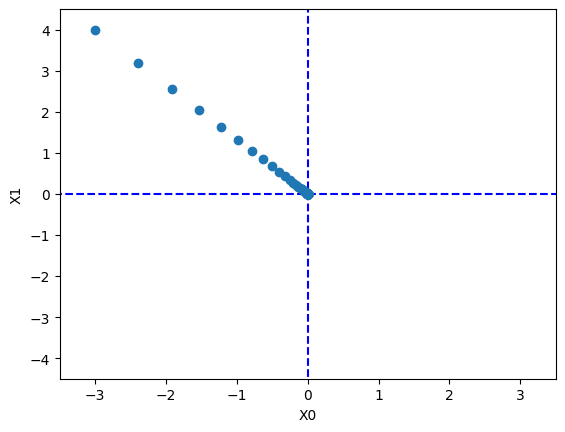

In [131]:
def function_3(X):
    return X[0]**2 + X[1]**2

init_x = np.array([-3.0, 4.0])
lr = 0.1
step_num = 100
x, x_history = gradient_descent_history(function_3, init_x, lr, step_num)
print(x)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()


In [132]:
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_3, init_x=init_x, lr=10.0, step_num=100))
init_x = np.array([-3.0, 4.0])
print(gradient_descent(function_3, init_x=init_x, lr=1e-10, step_num=100))

[-2.58983747e+13 -1.29524862e+12]
[-2.99999994  3.99999992]


In [133]:
def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

In [134]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
    def predict(self, x):
        return np.dot(x, self.W)
    def lose(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error_label(y, t)
        return loss

In [135]:
net = simpleNet()
print(net.W)
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))
t = np.array([0, 0, 1])
print(net.lose(x, t))

[[-0.7328459  -1.67500788 -1.510772  ]
 [-0.36974503 -1.91848955 -0.96466103]]
[-0.77247806 -2.73164532 -1.77465812]
0
3.1916262835481852


In [136]:
# def f(W):
#     return net.lose(x, t)

f = lambda w: net.lose(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[-0.00640922 -0.43173201  0.43814123]
 [-0.00961383 -0.64759801  0.65721184]]
